In [ ]:
%%capture
!pip install kagglehub pandas matplotlib 'tensorflow[and-cuda]' supervision 

In [ ]:
import kagglehub
# Download latest version
path = kagglehub.dataset_download("gopalbhattrai/pascal-voc-2012-dataset")

print("Path to dataset files:", path)

/home/garvthakral/miniconda3/envs/dino/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /home/garvthakral/.cache/kagglehub/datasets/gopalbhattrai/pascal-voc-2012-dataset/versions/1


In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

2025-09-19 16:29:08.762196: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Exception ignored in: <function _WeakValueDictionary.__init__.<locals>.KeyedRef.remove at 0x7595c9d0cb80>
Traceback (most recent call last):
  File "<frozen importlib._bootstrap>", line 82, in remove
KeyboardInterrupt: 


In [ ]:
# !ls /home/garvthakral/.cache/kagglehub/datasets/gopalbhattrai/pascal-voc-2012-dataset/versions/1/VOC2012_train_val/VOC2012_train_val/JPEGImages

In [ ]:
# !cat /home/garvthakral/.cache/kagglehub/datasets/gopalbhattrai/pascal-voc-2012-dataset/versions/1/VOC2012_train_val/VOC2012_train_val/ImageSets/Layout/train.txt
!ls /home/garvthakral/.cache/kagglehub/datasets/gopalbhattrai/pascal-voc-2012-dataset/versions/1/VOC2012_train_val/VOC2012_train_val/Annotations/2007_000027.xml

/home/garvthakral/.cache/kagglehub/datasets/gopalbhattrai/pascal-voc-2012-dataset/versions/1/VOC2012_train_val/VOC2012_train_val/Annotations/2007_000027.xml


In [ ]:
import xml.etree.ElementTree as ET

tree = ET.parse('/home/garvthakral/.cache/kagglehub/datasets/gopalbhattrai/pascal-voc-2012-dataset/versions/1/VOC2012_train_val/VOC2012_train_val/Annotations/2007_000027.xml')
root = tree.getroot()

for obj in root.findall('object'):
    cls = obj.find('name').text
    bndbox = obj.find('bndbox')
    xmin = int(bndbox.find('xmin').text)
    ymin = int(bndbox.find('ymin').text)
    xmax = int(bndbox.find('xmax').text)
    ymax = int(bndbox.find('ymax').text)
    print(cls, xmin, ymin, xmax, ymax)

    # Optional: parse parts if needed
    for part in obj.findall('part'):
        part_name = part.find('name').text
        part_box = part.find('bndbox')
        pxmin = int(part_box.find('xmin').text)
        pymin = int(part_box.find('ymin').text)
        pxmax = int(part_box.find('xmax').text)
        pymax = int(part_box.find('ymax').text)
        print('   Part:', part_name, pxmin, pymin, pxmax, pymax)


person 174 101 349 351
   Part: head 169 104 209 146
   Part: hand 278 210 297 233
   Part: foot 273 333 297 354
   Part: foot 319 307 340 326


In [ ]:
import supervision as sv
import cv2
import numpy as np

def infer(imagePath,coordinates = None):
    image = cv2.imread(imagePath)
    
    if coordinates == None:
        return image
    
    detections = sv.Detections(
        xyxy=np.array([coordinates]),
        class_id=np.array([0]),
        confidence=np.array([0.94])
    )
    
    # Create annotator using current API
    annotator = sv.BoxAnnotator()  # <- new name
    annotated_frame = annotator.annotate(scene=image.copy(), detections=detections)
    
    return annotated_frame

In [ ]:
# sv.plot_image(infer("/home/garvthakral/.cache/kagglehub/datasets/gopalbhattrai/pascal-voc-2012-dataset/versions/1/VOC2012_train_val/VOC2012_train_val/JPEGImages/2007_000027.jpg",coordinates= [174, 101, 349, 351]))

In [ ]:
id_to_label_map = {
    0: "background",1: "aeroplane",2: "bicycle",3: "bird",4: "boat",
    5: "bottle",6: "bus",7: "car",8: "cat",
    9: "chair",10: "cow",11: "diningtable",12: "dog",
    13: "horse",14: "motorbike",15: "person",16: "pottedplant",
    17: "sheep",18: "sofa",19: "train",20: "tvmonitor"
}
label_to_id_map = {v:k for k,v in id_to_label_map.items()}

In [ ]:
# def loss_function(y_true, y_pred, 
#                           lambda_obj=1.0, lambda_noobj=0.5, lambda_bbox=0.1, lambda_class=1.0):
    
#     # Split predictions and ground truth
#     obj_true = y_true[:, 0]  # objectness
#     bbox_true = y_true[:, 1:5]  # bounding box
#     class_true = y_true[:, 5:25]  # class probabilities
    
#     obj_pred = y_pred[:, 0]
#     bbox_pred = y_pred[:, 1:5]  
#     class_pred = y_pred[:, 5:25]
    
#     # Create masks
#     obj_mask = tf.cast(obj_true > 0.5, tf.float32)  # where objects exist
#     noobj_mask = tf.cast(obj_true <= 0.5, tf.float32)  # where no objects
    
#     # Objectness loss
#     obj_loss_pos = lambda_obj * obj_mask * tf.square(obj_true - obj_pred)
#     obj_loss_neg = lambda_noobj * noobj_mask * tf.square(obj_true - obj_pred)
#     obj_loss = tf.reduce_mean(obj_loss_pos + obj_loss_neg)
    
#     # Bounding box loss (only where objects exist)
#     bbox_loss = lambda_bbox * tf.reduce_mean(
#         obj_mask * tf.reduce_sum(tf.square(bbox_true - bbox_pred), axis=1)
#     )
    
#     # Classification loss (only where objects exist) 
#     class_loss = lambda_class * tf.reduce_mean(
#         obj_mask * tf.keras.losses.categorical_crossentropy(class_true, class_pred)
#     )
    
#     total_loss = obj_loss + bbox_loss + class_loss
#     return total_loss


In [ ]:
import tensorflow as tf
def loss_function(y_true , y_pred):
    
    obj_true = y_true[...,0]

    bbox_true = y_true[...,1:5]
    class_true = y_true[...,5:]

    obj_pred = y_pred[...,0]
    bbox_pred = y_pred[...,1:5]
    class_pred = y_pred[...,5:]

    obj_mask = tf.expand_dims(tf.cast(obj_true > 0.5,dtype = tf.float32),axis  = 1)[...,None]

    obj_loss  = tf.reduce_mean((obj_true - obj_pred)**2)
    pos = tf.reduce_sum(obj_mask) + 1e-6
    bbox_loss = tf.reduce_sum(((bbox_true - bbox_pred)**2) * obj_mask) / pos
    class_loss = tf.reduce_sum(((class_true - class_pred)**2) * obj_mask) / pos

    loss = obj_loss+bbox_loss+class_loss 


    return loss 

# y_true = [
#     [1.0, 0.2, 0.3, 0.8, 0.9, 0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],  # has car
#     [0.0, 0.0, 0.0, 0.0, 0.0, 1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],  # no object  
#     [1.0, 0.1, 0.1, 0.6, 0.7, 0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]   # has person
# ]

# # Model Predictions (y_pred) 
# y_pred = [
#     [0.8, 0.25, 0.35, 0.75, 0.85, 0.1,0.1,0.7,0.1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
#     [0.2, 0.1, 0.2, 0.3, 0.4,   0.8,0.1,0.1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
#     [0.9, 0.12, 0.08, 0.58, 0.72, 0.1,0.8,0.1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
# ]
# loss_function(tf.constant(y_true), tf.constant(y_pred))

In [ ]:
with open('/home/garvthakral/.cache/kagglehub/datasets/gopalbhattrai/pascal-voc-2012-dataset/versions/1/VOC2012_train_val/VOC2012_train_val/ImageSets/Main/train.txt','r') as f:
    reader = f.read()
train_arr = reader.split('\n')
train_arr = [x for x in train_arr if x!='']

train_dataset = tf.data.Dataset.from_tensor_slices(train_arr)
with open('/home/garvthakral/.cache/kagglehub/datasets/gopalbhattrai/pascal-voc-2012-dataset/versions/1/VOC2012_train_val/VOC2012_train_val/ImageSets/Main/val.txt','r') as f:
    reader = f.read()
val_arr = reader.split('\n')
val_dataset = tf.data.Dataset.from_tensor_slices(val_arr)

I0000 00:00:1758187641.401784  428332 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4149 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


In [ ]:
# train_arr = [x for x in train_arr if x!='']
train_arr

['2008_000008',
 '2008_000015',
 '2008_000019',
 '2008_000023',
 '2008_000028',
 '2008_000033',
 '2008_000036',
 '2008_000037',
 '2008_000041',
 '2008_000045',
 '2008_000053',
 '2008_000060',
 '2008_000066',
 '2008_000070',
 '2008_000074',
 '2008_000085',
 '2008_000089',
 '2008_000093',
 '2008_000095',
 '2008_000096',
 '2008_000097',
 '2008_000099',
 '2008_000103',
 '2008_000105',
 '2008_000109',
 '2008_000112',
 '2008_000128',
 '2008_000131',
 '2008_000132',
 '2008_000141',
 '2008_000142',
 '2008_000143',
 '2008_000144',
 '2008_000148',
 '2008_000151',
 '2008_000154',
 '2008_000162',
 '2008_000176',
 '2008_000181',
 '2008_000185',
 '2008_000187',
 '2008_000188',
 '2008_000189',
 '2008_000191',
 '2008_000192',
 '2008_000193',
 '2008_000196',
 '2008_000197',
 '2008_000199',
 '2008_000202',
 '2008_000207',
 '2008_000217',
 '2008_000226',
 '2008_000227',
 '2008_000235',
 '2008_000236',
 '2008_000237',
 '2008_000238',
 '2008_000252',
 '2008_000255',
 '2008_000259',
 '2008_000260',
 '2008_0

In [ ]:
import xml.etree.ElementTree as ET
def preprocess_ds(x,img_dir , ann_dir , grid_size = 3):
    img_path = tf.strings.join([img_dir, "/", x, ".jpg"])
    xml_path = tf.strings.join([ann_dir, "/", x, ".xml"])
    
    def _xmlparser(xml_path_str):
            xml_path_str = xml_path_str.numpy().decode()  # convert bytes to str
            tree = ET.parse(xml_path_str)
            root = tree.getroot()
            dims = []
            for x in root.find('size'):
                dims.append(int(x.text))

            width , height , channels = dims
            objects_array = []
            for x in root.findall('object'):
                objects_array.append(x)
            
            # An array to store all the bounding box coordinates for every image in the image
            
            name_arr = []
            bndbox_array = []

            for x in objects_array:
                # Bounding box logic
                temp_arr = []
                for y in x.find('bndbox'):
                    temp_arr.append(int(y.text))
                bndbox_array.append(temp_arr)
                name_arr.append(x.find('name').text)    


            index_arr = [name_to_ix[name] for name in name_arr]


            num_classes = len(class_names)-1

            default_y_label = [0] + [0]*4 + [0]*num_classes

            y_label_arr = np.zeros((grid_size, grid_size, len(default_y_label)), dtype='float')

            # Initialize each cell with the default label
            for i in range(grid_size):
                for j in range(grid_size):
                    y_label_arr[i][j] = default_y_label.copy()

            def label_array():
                y = np.zeros((grid_size, grid_size, 5 + num_classes), dtype=np.float32)
                S = grid_size
                for i, (xmin, ymin, xmax, ymax) in enumerate(bndbox_array):
                    # pad/resize math
                    scale = min(448/width, 448/height)
                    new_w, new_h = width*scale, height*scale
                    pad_x, pad_y = (448 - new_w)/2.0, (448 - new_h)/2.0

                    # absolute coords in padded image space
                    cx_abs = ((xmin + xmax)/2.0)*scale + pad_x
                    cy_abs = ((ymin + ymax)/2.0)*scale + pad_y
                    bw_abs = (xmax - xmin)*scale
                    bh_abs = (ymax - ymin)*scale

                    # normalize to 448 and cast
                    cx = np.float32(cx_abs / 448.0)
                    cy = np.float32(cy_abs / 448.0)
                    bw = np.float32(bw_abs / 448.0)
                    bh = np.float32(bh_abs / 448.0)

                    # clamp to [0,1]
                    cx = np.clip(cx, 0.0, 1.0)
                    cy = np.clip(cy, 0.0, 1.0)
                    bw = np.clip(bw, 0.0, 1.0)
                    bh = np.clip(bh, 0.0, 1.0)

                    # pick cell from (cx, cy)
                    col = min(int(cx * S), S-1)
                    row = min(int(cy * S), S-1)

                    if y[row, col, 0] == 0:  # simple policy: first box wins
                        onehot = np.zeros(num_classes, dtype=np.float32)
                        onehot[index_arr[i]] = 1.0
                        y[row, col, :5] = [1.0, cx, cy, bw, bh]
                        y[row, col, 5:] = onehot
                return y

            y_true = label_array()

            


            return y_true
    
    num_classes = len(class_names)-1
    y_label = tf.py_function(func=_xmlparser, inp=[xml_path], Tout=tf.float32)
    y_label.set_shape([grid_size, grid_size, 5 + num_classes])
    # Load and preprocess image
    img_raw = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img_raw, channels=3)
    img = tf.image.resize_with_pad(img, 448, 448)
    img = tf.cast(img, tf.float32) / 255.0

    return img , y_label


In [ ]:
import xml.etree.ElementTree as ET
import numpy as np
import tensorflow as tf

tree = ET.parse('/home/garvthakral/.cache/kagglehub/datasets/gopalbhattrai/pascal-voc-2012-dataset/versions/1/VOC2012_train_val/VOC2012_train_val/Annotations/2007_000033.xml')
root = tree.getroot()

nameList = []
bndBoxList = []

# Get original image width and height
size = root.find('size')
W = int(size.find('width').text)
H = int(size.find('height').text)

# Extract objects + bounding boxes
for x in root.findall('object'):
    name = x.find('name').text
    bndbox = x.find('bndbox')
    xmin = int(bndbox.find('xmin').text)
    ymin = int(bndbox.find('ymin').text)
    xmax = int(bndbox.find('xmax').text)
    ymax = int(bndbox.find('ymax').text)

    # normalize using W, H
    xmin /= W
    xmax /= W
    ymin /= H
    ymax /= H

    nameList.append(name)
    bndBoxList.append([xmin, ymin, xmax, ymax])

bndBoxList = np.array(bndBoxList, dtype=np.float32)
print("Normalized bounding boxes:\n", bndBoxList)

# Example: building label tensor for the first box
for x in range(len(nameList)):
    one_hot_class = tf.one_hot(label_to_id_map[nameList[x]], depth=20)
    temp = tf.constant([1] + bndBoxList[x].tolist(), dtype=tf.float32)  # [objectness, xmin, ymin, xmax, ymax]
    y_label = tf.concat([temp, one_hot_class], axis=0)
    print("Final label vector:", y_label.numpy())
    break


Normalized bounding boxes:
 [[0.018      0.29234973 0.998      0.71857923]
 [0.842      0.5464481  0.964      0.61748636]
 [0.65       0.5136612  0.822      0.60928965]]
Final label vector: [1.         0.018      0.29234973 0.998      0.71857923 0.
 1.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ]


In [ ]:
img_dir = '/home/garvthakral/.cache/kagglehub/datasets/gopalbhattrai/pascal-voc-2012-dataset/versions/1/VOC2012_train_val/VOC2012_train_val/JPEGImages'
ann_dir = '/home/garvthakral/.cache/kagglehub/datasets/gopalbhattrai/pascal-voc-2012-dataset/versions/1/VOC2012_train_val/VOC2012_train_val/Annotations'
# for x in train_dataset.map(lambda x:preprocess(x,img_dir,ann_dir)).take(1):
#     print(x)

In [ ]:
# image_dataset = tf.raw_ops.LoadDataset(
#     path ="/home/garvthakral/.cache/kagglehub/datasets/gopalbhattrai/pascal-voc-2012-dataset/versions/1/VOC2012_train_val/VOC2012_train_val/JPEGImages",   
# )

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, LeakyReLU, MaxPooling2D, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Concatenate

def TinyYOLO_Light(input_shape=(448, 448, 3), num_classes=20):
    """
    Simplest improvement: Remove global pooling, use spatial averaging
    """
    inputs = Input(shape=input_shape)
    
    # Backbone - same as original
    x = Conv2D(32, (3,3), strides=1, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.1)(x)
    x = MaxPooling2D((2,2))(x)
    
    x = Conv2D(64, (3,3), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.1)(x)
    x = MaxPooling2D((2,2))(x)
    
    x = Conv2D(128, (3,3), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.1)(x)
    x = MaxPooling2D((2,2))(x)
    
    x = Conv2D(256, (3,3), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.1)(x)
    x = MaxPooling2D((2,2))(x)
    
    x = Conv2D(512, (3,3), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.1)(x)
    x = MaxPooling2D((2,2))(x)
    
    # Detection head
    x = Conv2D(1024, (3,3), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.1)(x)
    
    x = Conv2D(1024, (3,3), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.1)(x)
    
    # KEY CHANGE: Direct prediction layer instead of global pooling
    x = Conv2D(25, (3,3), padding='same')(x)  # Direct prediction
    
    # Average across spatial dimensions (preserve some spatial info in gradients)
    outputs = GlobalAveragePooling2D()(x) # Shape: (batch, 25)
    
    model = Model(inputs, outputs)
    return model


# Create model
model = TinyYOLO_Light()
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 448, 448, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 448, 448, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 448, 448, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 448, 448, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 224, 224, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 224, 224, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 112, 112, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 112, 112, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 56, 56, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 56, 56, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 28, 28, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 28, 28, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 14, 14, 1024)   │     4,719,616 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 15,968,985 (60.92 MB)

 Trainable params: 15,962,905 (60.89 MB)

 Non-trainable params: 6,080 (23.75 KB)

In [ ]:
def iou_metric(y_true, y_pred):
    """Calculate IoU metric for YOLO predictions"""
    # Extract objectness mask (only compute IoU where objects exist)
    obj_true = y_true[:, 0]
    obj_mask = tf.cast(obj_true > 0.5, tf.float32)
    
    # Extract bounding boxes
    bbox_true = y_true[:, 1:5]  # [xmin, ymin, xmax, ymax]
    bbox_pred = y_pred[:, 1:5]
    
    # Calculate intersection
    xmin_inter = tf.maximum(bbox_true[:, 0], bbox_pred[:, 0])
    ymin_inter = tf.maximum(bbox_true[:, 1], bbox_pred[:, 1])
    xmax_inter = tf.minimum(bbox_true[:, 2], bbox_pred[:, 2])
    ymax_inter = tf.minimum(bbox_true[:, 3], bbox_pred[:, 3])
    
    # Calculate intersection area
    inter_width = tf.maximum(0.0, xmax_inter - xmin_inter)
    inter_height = tf.maximum(0.0, ymax_inter - ymin_inter)
    intersection = inter_width * inter_height
    
    # Calculate union
    area_true = (bbox_true[:, 2] - bbox_true[:, 0]) * (bbox_true[:, 3] - bbox_true[:, 1])
    area_pred = (bbox_pred[:, 2] - bbox_pred[:, 0]) * (bbox_pred[:, 3] - bbox_pred[:, 1])
    union = area_true + area_pred - intersection
    
    # Calculate IoU
    iou = intersection / (union + 1e-7)  # Add small epsilon to avoid division by zero
    
    # Only compute IoU where objects exist
    masked_iou = iou * obj_mask
    
    # Return mean IoU only for samples with objects
    num_objects = tf.reduce_sum(obj_mask)
    mean_iou = tf.cond(
        num_objects > 0,
        lambda: tf.reduce_sum(masked_iou) / num_objects,
        lambda: 0.0
    )
    
    return mean_iou


In [ ]:
train_dataset_x = train_dataset.map(lambda x:preprocess(x,img_dir,ann_dir)).batch(10).prefetch(tf.data.AUTOTUNE)
model.compile(
    loss = loss_function,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics = [iou_metric]
)
model.fit(train_dataset_x , epochs = 30)

Epoch 1/30


2025-09-18 14:57:26.472646: I external/local_xla/xla/service/service.cc:163] XLA service 0x78aff801ef20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-09-18 14:57:26.472665: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2025-09-18 14:57:26.598059: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-09-18 14:57:27.149980: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91200
2025-09-18 14:57:29.940305: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.35GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


  1/572 ━━━━━━━━━━━━━━━━━━━━ 2:38:48 17s/step - iou_metric: 0.0000e+00 - loss: 7.9809

I0000 00:00:1758187659.486974  475097 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


572/572 ━━━━━━━━━━━━━━━━━━━━ 100s 146ms/step - iou_metric: 0.2777 - loss: 1.1550
Epoch 2/30
572/572 ━━━━━━━━━━━━━━━━━━━━ 78s 137ms/step - iou_metric: 0.2932 - loss: 0.9902
Epoch 3/30
572/572 ━━━━━━━━━━━━━━━━━━━━ 83s 145ms/step - iou_metric: 0.2963 - loss: 0.9622
Epoch 4/30
572/572 ━━━━━━━━━━━━━━━━━━━━ 86s 150ms/step - iou_metric: 0.2979 - loss: 0.9241
Epoch 5/30
572/572 ━━━━━━━━━━━━━━━━━━━━ 87s 153ms/step - iou_metric: 0.3020 - loss: 0.8915
Epoch 6/30
572/572 ━━━━━━━━━━━━━━━━━━━━ 90s 158ms/step - iou_metric: 0.3059 - loss: 0.8657
Epoch 7/30
572/572 ━━━━━━━━━━━━━━━━━━━━ 94s 165ms/step - iou_metric: 0.3103 - loss: 0.8409
Epoch 8/30
572/572 ━━━━━━━━━━━━━━━━━━━━ 94s 164ms/step - iou_metric: 0.3141 - loss: 0.8171
Epoch 9/30
572/572 ━━━━━━━━━━━━━━━━━━━━ 93s 163ms/step - iou_metric: 0.3167 - loss: 0.7933
Epoch 10/30
572/572 ━━━━━━━━━━━━━━━━━━━━ 90s 158ms/step - iou_metric: 0.3196 - loss: 0.7686
Epoch 11/30
572/572 ━━━━━━━━━━━━━━━━━━━━ 90s 158ms/step - iou_metric: 0.3223 - loss: 0.7427
Epoch 1

KeyboardInterrupt: 

In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [ ]:
pred = model.predict(train_dataset_x.take(1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 751ms/step


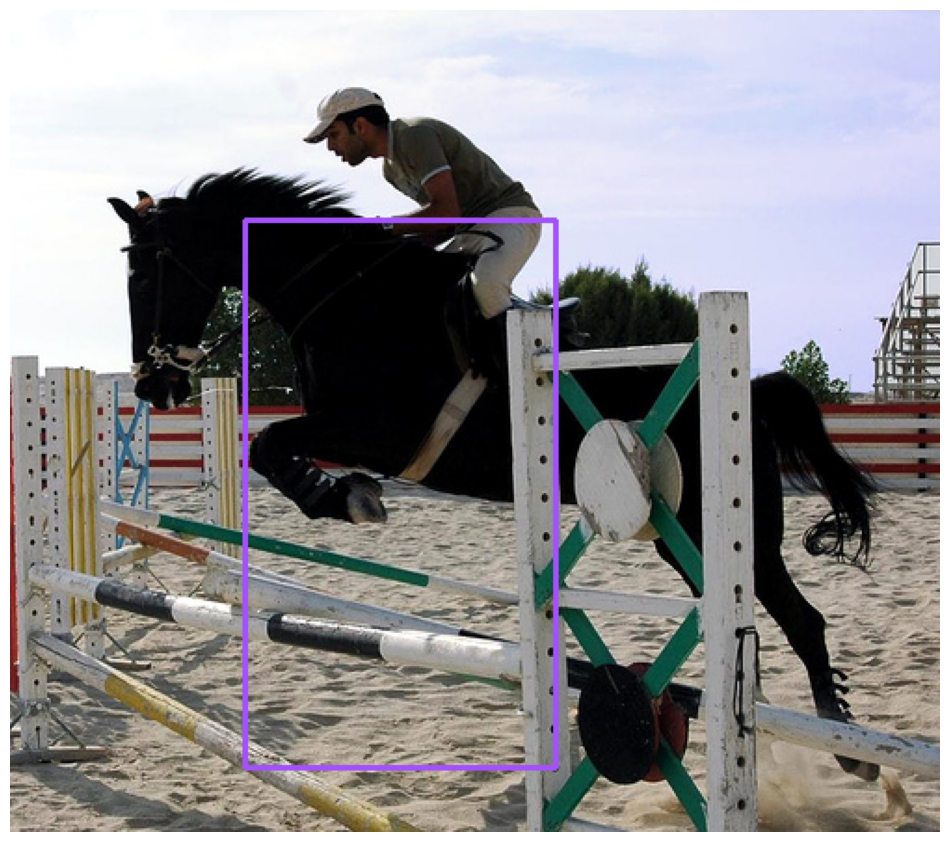

In [ ]:
pred[0]
image = cv2.imread("/home/garvthakral/.cache/kagglehub/datasets/gopalbhattrai/pascal-voc-2012-dataset/versions/1/VOC2012_train_val/VOC2012_train_val/JPEGImages/2008_000008.jpg")
detections = sv.Detections(
    xyxy=np.array([[pred[1][1]*500,pred[1][2]*486,pred[1][3]*500,pred[1][4]*486]]),
    class_id=np.array([0]),
    confidence=np.array([0.94])
)
# for i in range(10): 
#     print(np.argmax(pred[i][5:]))
# # print(id_to_label[pred[2][]]
# # Create annotator using current API
annotator = sv.BoxAnnotator()  # <- new name
annotated_frame = annotator.annotate(scene=image.copy(), detections=detections)
sv.plot_image(annotated_frame)


--- Image 1: 2008_000008.jpg ---
Objectness: 1.057
Predicted class: boat (confidence: 0.541)
Normalized bbox: [0.139, 0.183, 0.689, 0.762]


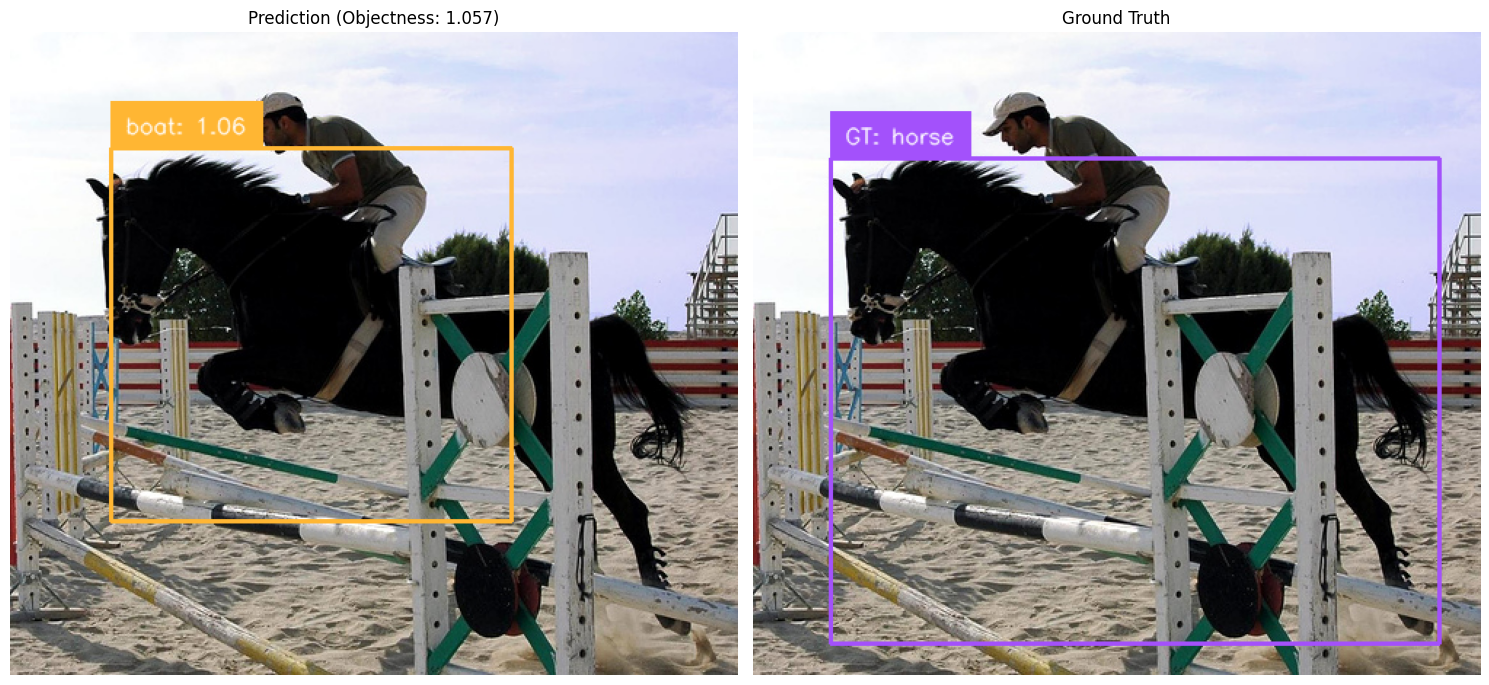


--- Image 2: 2007_000027.jpg ---
Objectness: 1.099
Predicted class: diningtable (confidence: 0.607)
Normalized bbox: [0.115, 0.131, 0.672, 0.904]


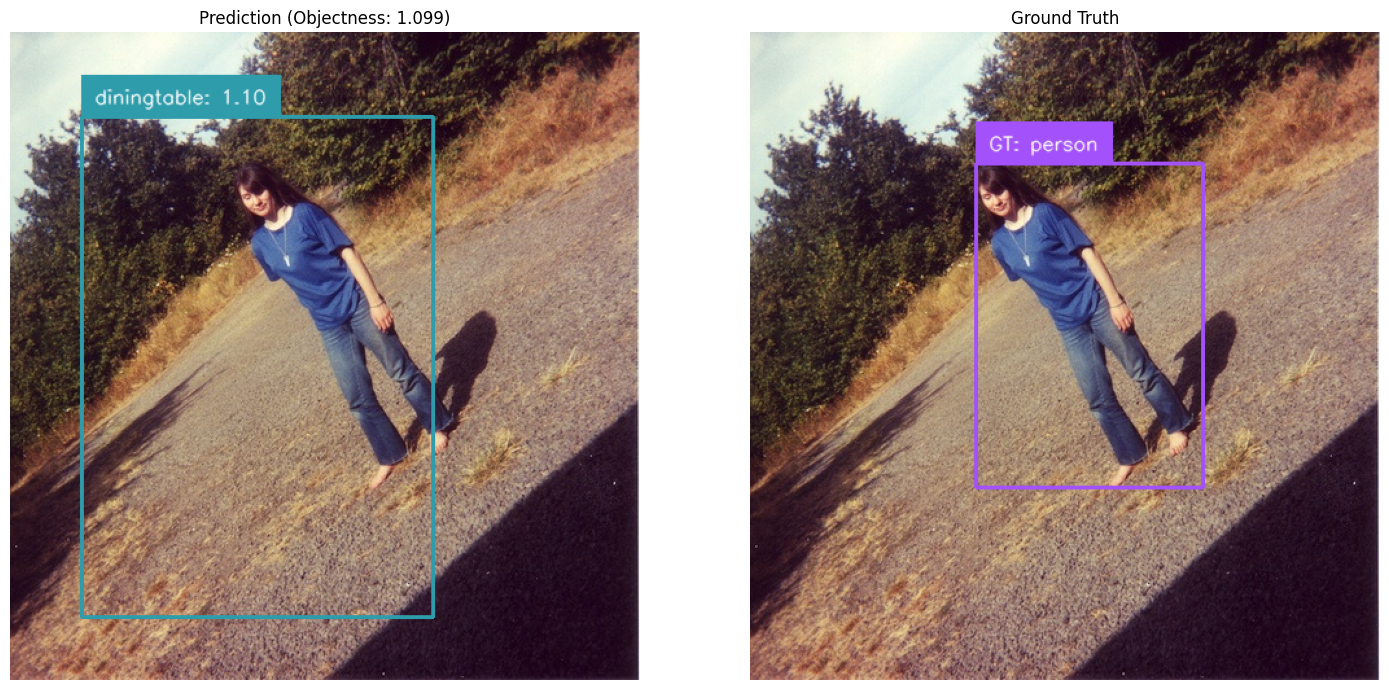


--- Image 3: 2007_000033.jpg ---
Objectness: 1.038
Predicted class: cow (confidence: 0.410)
Normalized bbox: [0.167, 0.222, 0.680, 0.661]


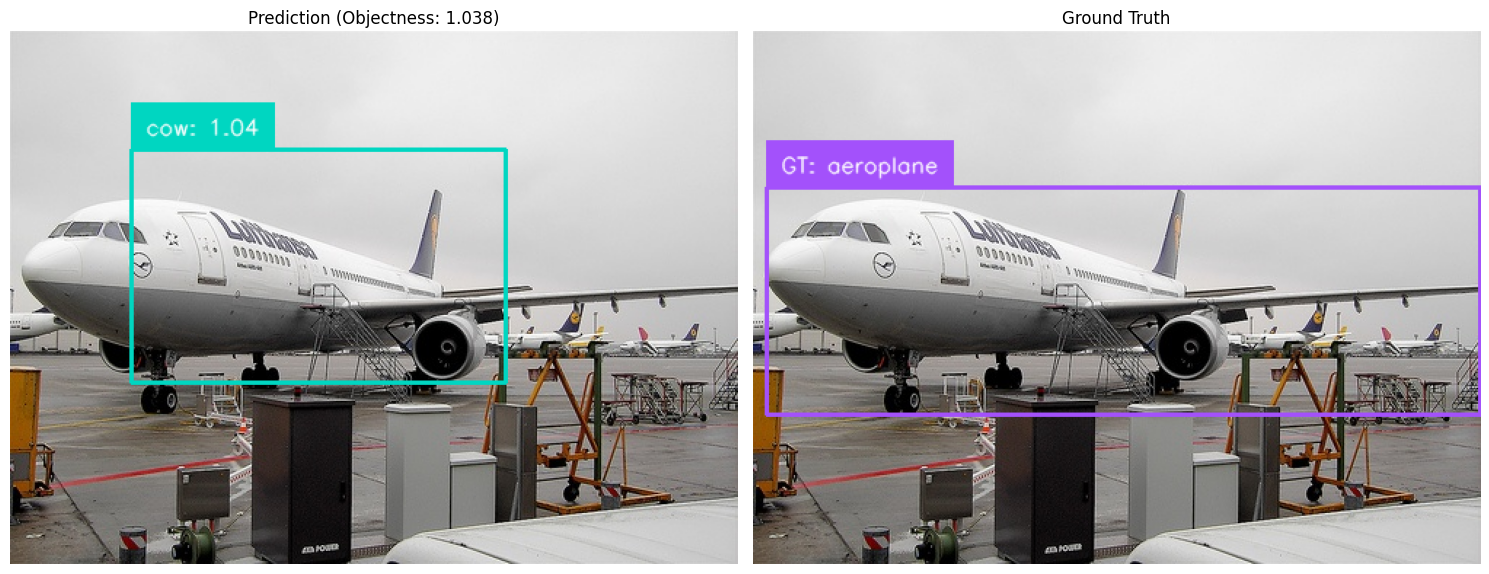

In [ ]:
# Label mapping (from your notebook)
id_to_label_map = {
    0: "background", 1: "aeroplane", 2: "bicycle", 3: "bird", 4: "boat",
    5: "bottle", 6: "bus", 7: "car", 8: "cat",
    9: "chair", 10: "cow", 11: "diningtable", 12: "dog",
    13: "horse", 14: "motorbike", 15: "person", 16: "pottedplant",
    17: "sheep", 18: "sofa", 19: "train", 20: "tvmonitor"
}

def preprocess_image(image_path):
    """Preprocess a single image for inference"""
    img_raw = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img_raw, channels=3)
    original_shape = tf.shape(img)[:2]  # H, W
    
    # Resize with padding (same as training)
    img = tf.image.resize_with_pad(img, 448, 448)
    img = tf.cast(img, tf.float32) / 255.0
    img = tf.expand_dims(img, axis=0)  # Add batch dimension
    
    return img, original_shape

def get_ground_truth_bbox(xml_path):
    """Extract ground truth bounding box from XML annotation"""
    tree = ET.parse(xml_path)
    root = tree.getroot()
    
    # Get image dimensions
    size = root.find('size')
    W = int(size.find('width').text)
    H = int(size.find('height').text)
    
    # Get first object (following your training approach)
    obj = root.find('object')
    if obj is not None:
        cls = obj.find('name').text
        bndbox = obj.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        
        return [xmin, ymin, xmax, ymax], cls, (W, H)
    return None, None, (W, H)

def denormalize_bbox(norm_bbox, original_shape):
    """Convert normalized bbox back to pixel coordinates"""
    H, W = original_shape[0], original_shape[1]
    xmin, ymin, xmax, ymax = norm_bbox
    
    # Denormalize
    xmin_pixel = int(xmin * W)
    ymin_pixel = int(ymin * H)
    xmax_pixel = int(xmax * W)
    ymax_pixel = int(ymax * H)
    
    return [xmin_pixel, ymin_pixel, xmax_pixel, ymax_pixel]

def inference_with_visualization(model, image_path, xml_path=None, confidence_threshold=0.5):
    """Run inference and visualize results"""
    
    # Preprocess image
    processed_img, original_shape = preprocess_image(image_path)
    
    # Run prediction
    prediction = model.predict(processed_img, verbose=0)[0]  # Get first (and only) prediction
    
    # Parse prediction
    objectness = prediction[0]
    bbox_norm = prediction[1:5]  # normalized coordinates
    class_probs = prediction[5:]
    predicted_class_id = np.argmax(class_probs)
    predicted_class_name = id_to_label_map[predicted_class_id]
    max_class_prob = np.max(class_probs)
    
    print(f"Objectness: {objectness:.3f}")
    print(f"Predicted class: {predicted_class_name} (confidence: {max_class_prob:.3f})")
    print(f"Normalized bbox: [{bbox_norm[0]:.3f}, {bbox_norm[1]:.3f}, {bbox_norm[2]:.3f}, {bbox_norm[3]:.3f}]")
    
    # Load original image
    original_img = cv2.imread(image_path)
    H, W = original_img.shape[:2]
    
    # Create visualization
    fig, axes = plt.subplots(1, 2 if xml_path else 1, figsize=(15, 7))
    if xml_path:
        axes = [axes[0], axes[1]] if hasattr(axes, '__len__') else [axes, None]
    else:
        axes = [axes]
    
    # Show prediction if confidence is above threshold
    if objectness > confidence_threshold:
        # Denormalize predicted bbox
        pred_bbox_pixel = denormalize_bbox(bbox_norm, (H, W))
        
        # Create detection for supervision
        detections = sv.Detections(
            xyxy=np.array([pred_bbox_pixel]),
            class_id=np.array([predicted_class_id]),
            confidence=np.array([objectness])
        )
        
        # Annotate image
        annotator = sv.BoxAnnotator()
        label_annotator = sv.LabelAnnotator()
        
        annotated_img = annotator.annotate(scene=original_img.copy(), detections=detections)
        labels = [f"{predicted_class_name}: {objectness:.2f}"]
        annotated_img = label_annotator.annotate(scene=annotated_img, detections=detections, labels=labels)
        
        # Convert BGR to RGB for matplotlib
        annotated_img = cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB)
        
        axes[0].imshow(annotated_img)
        axes[0].set_title(f'Prediction (Objectness: {objectness:.3f})')
        axes[0].axis('off')
    else:
        # Show original image without annotation
        original_img_rgb = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
        axes[0].imshow(original_img_rgb)
        axes[0].set_title(f'Prediction (Low confidence: {objectness:.3f})')
        axes[0].axis('off')
    
    # Show ground truth if XML is provided
    if xml_path and len(axes) > 1:
        gt_bbox, gt_class, _ = get_ground_truth_bbox(xml_path)
        if gt_bbox:
            # Create ground truth detection
            gt_detections = sv.Detections(
                xyxy=np.array([gt_bbox]),
                class_id=np.array([0]),  # Just for visualization
                confidence=np.array([1.0])
            )
            
            # Annotate ground truth
            gt_annotated = annotator.annotate(scene=original_img.copy(), detections=gt_detections)
            gt_labels = [f"GT: {gt_class}"]
            gt_annotated = label_annotator.annotate(scene=gt_annotated, detections=gt_detections, labels=gt_labels)
            
            # Convert BGR to RGB
            gt_annotated = cv2.cvtColor(gt_annotated, cv2.COLOR_BGR2RGB)
            
            axes[1].imshow(gt_annotated)
            axes[1].set_title('Ground Truth')
            axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return {
        'objectness': objectness,
        'bbox_normalized': bbox_norm,
        'bbox_pixel': denormalize_bbox(bbox_norm, (H, W)) if objectness > confidence_threshold else None,
        'predicted_class': predicted_class_name,
        'class_confidence': max_class_prob
    }

def batch_inference(model, image_paths, xml_paths=None, confidence_threshold=0.5):
    """Run inference on multiple images"""
    results = []
    
    for i, img_path in enumerate(image_paths):
        print(f"\n--- Image {i+1}: {img_path.split('/')[-1]} ---")
        xml_path = xml_paths[i] if xml_paths else None
        
        result = inference_with_visualization(
            model, img_path, xml_path, confidence_threshold
        )
        results.append(result)
    
    return results

def iou_metric(y_true, y_pred):
    """Calculate IoU metric for YOLO predictions"""
    # Extract objectness mask (only compute IoU where objects exist)
    obj_true = y_true[:, 0]
    obj_mask = tf.cast(obj_true > 0.5, tf.float32)
    
    # Extract bounding boxes
    bbox_true = y_true[:, 1:5]  # [xmin, ymin, xmax, ymax]
    bbox_pred = y_pred[:, 1:5]
    
    # Calculate intersection
    xmin_inter = tf.maximum(bbox_true[:, 0], bbox_pred[:, 0])
    ymin_inter = tf.maximum(bbox_true[:, 1], bbox_pred[:, 1])
    xmax_inter = tf.minimum(bbox_true[:, 2], bbox_pred[:, 2])
    ymax_inter = tf.minimum(bbox_true[:, 3], bbox_pred[:, 3])
    
    # Calculate intersection area
    inter_width = tf.maximum(0.0, xmax_inter - xmin_inter)
    inter_height = tf.maximum(0.0, ymax_inter - ymin_inter)
    intersection = inter_width * inter_height
    
    # Calculate union
    area_true = (bbox_true[:, 2] - bbox_true[:, 0]) * (bbox_true[:, 3] - bbox_true[:, 1])
    area_pred = (bbox_pred[:, 2] - bbox_pred[:, 0]) * (bbox_pred[:, 3] - bbox_pred[:, 1])
    union = area_true + area_pred - intersection
    
    # Calculate IoU
    iou = intersection / (union + 1e-7)  # Add small epsilon to avoid division by zero
    
    # Only compute IoU where objects exist
    masked_iou = iou * obj_mask
    
    # Return mean IoU only for samples with objects
    num_objects = tf.reduce_sum(obj_mask)
    mean_iou = tf.cond(
        num_objects > 0,
        lambda: tf.reduce_sum(masked_iou) / num_objects,
        lambda: 0.0
    )
    
    return mean_iou

def classification_accuracy_metric(y_true, y_pred):
    """Calculate classification accuracy only where objects exist"""
    # Extract objectness mask
    obj_true = y_true[:, 0]
    obj_mask = tf.cast(obj_true > 0.5, tf.float32)
    
    # Extract class predictions
    class_true = y_true[:, 5:]
    class_pred = y_pred[:, 5:]
    
    # Get predicted class indices
    true_classes = tf.argmax(class_true, axis=1)
    pred_classes = tf.argmax(class_pred, axis=1)
    
    # Check if classifications are correct
    correct_predictions = tf.cast(tf.equal(true_classes, pred_classes), tf.float32)
    
    # Only compute accuracy where objects exist
    masked_correct = correct_predictions * obj_mask
    
    # Return mean accuracy only for samples with objects
    num_objects = tf.reduce_sum(obj_mask)
    class_accuracy = tf.cond(
        num_objects > 0,
        lambda: tf.reduce_sum(masked_correct) / num_objects,
        lambda: 0.0
    )
    
    return class_accuracy

def objectness_accuracy_metric(y_true, y_pred):
    """Calculate objectness prediction accuracy"""
    obj_true = y_true[:, 0]
    obj_pred = y_pred[:, 0]
    
    # Convert to binary predictions (threshold at 0.5)
    obj_true_binary = tf.cast(obj_true > 0.5, tf.float32)
    obj_pred_binary = tf.cast(obj_pred > 0.5, tf.float32)
    
    # Calculate accuracy
    correct_obj = tf.cast(tf.equal(obj_true_binary, obj_pred_binary), tf.float32)
    return tf.reduce_mean(correct_obj)

# Example usage:
if __name__ == "__main__":
    # Updated model compilation with meaningful metrics:
    """
    model.compile(
        loss=loss_function,
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        metrics=[iou_metric, classification_accuracy_metric, objectness_accuracy_metric]
    )
    """
    
    # Example paths (update these to your actual paths)
    base_path = "/home/garvthakral/.cache/kagglehub/datasets/gopalbhattrai/pascal-voc-2012-dataset/versions/1/VOC2012_train_val/VOC2012_train_val"
    
    # Single image inference
    img_path = f"{base_path}/JPEGImages/2008_000008.jpg"
    xml_path = f"{base_path}/Annotations/2008_000008.xml"
    
    # Uncomment when you have a trained model:
    # result = inference_with_visualization(model, img_path, xml_path)
    # print("Final result:", result)
    
    # Batch inference example
    image_paths = [
        f"{base_path}/JPEGImages/2008_000008.jpg",
        f"{base_path}/JPEGImages/2007_000027.jpg",
        f"{base_path}/JPEGImages/2007_000033.jpg"
    ]
    xml_paths = [
        f"{base_path}/Annotations/2008_000008.xml",
        f"{base_path}/Annotations/2007_000027.xml", 
        f"{base_path}/Annotations/2007_000033.xml"
    ]
    
    # Uncomment when you have a trained model:
    # batch_results = batch_inference(model, image_paths, xml_paths)
    # Uncomment when you have a trained model:
    batch_results = batch_inference(model, image_paths, xml_paths)